In [1]:
# Загружаем библиотеки
import pandas as pd # Датафреймы pandas
import matplotlib.pyplot as plt # Графики
from sklearn.datasets import fetch_covtype # Датасет типов лесов
from sklearn.model_selection import train_test_split # Разделение выборки на обучающую и тестовую
from sklearn.ensemble import RandomForestClassifier # Модель случайного леса
from sklearn.feature_selection import mutual_info_classif # Оценка информативности признаков для задачи классификации

#### Загрузка и обработка данных

In [2]:
# Загружаем признаки и целевые значения
X, y = fetch_covtype(return_X_y = True, as_frame = True)

In [3]:
# Разделение выборки на обучающую и тестовую
# Для ускорения работы берём первые 10000 строк
X_train, X_test, y_train, y_test = train_test_split(X[:10000], y[:10000], random_state = 42)  

In [4]:
print(f'Количество пропусков в данных: {X[:10000].isna().sum().sum()}')

Количество пропусков в данных: 0


In [5]:
# Перебираем признаки попарно и считаем коэффициент корелляции
print('Следующие пары признаков имеют высокую степень корелляции:')
for feature_1 in X_train.columns:
    for feature_2 in X_train.columns:
        corr = X_train[feature_1].corr(X_train[feature_2])
        if (abs(corr) > 0.7) & (feature_1 > feature_2):
            print(f'({feature_1} - {feature_2}) R = {round(corr, 2)}')
print('Пары признаков со степенью корелляции близкой к 1 отсутствуют, следовательно все признаки важны')

Следующие пары признаков имеют высокую степень корелляции:
(Hillshade_9am - Hillshade_3pm) R = -0.77
(Wilderness_Area_3 - Elevation) R = -0.83
Пары признаков со степенью корелляции близкой к 1 отсутствуют, следовательно все признаки важны


#### Функции обучения модели и построения графика

In [6]:
# Функция принимает на вход список с названиями признаков, отсортированных по убыванию значимости
# Обучает модель на количестве признаков от 1 до максимального, определяет значение показателя качества модели
# На выходе словарь вида: количество признаков - показазатель качества
def score_calc(feature_list, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    # Создаем модель RandomForest
    model = RandomForestClassifier(random_state = 42)
    # Результаты записываем в словарь
    result = {}
    
    # Берём признаки в количестве от 1 до полного количества
    for feature_quantity in range(1, len(feature_list) + 1):
        model.fit(X_train[feature_list[:feature_quantity]], y_train)
        result[feature_quantity] = model.score(X_test[feature_list[:feature_quantity]], y_test) 
    return(result)

In [7]:
# Функция принимает на вход словарь вида: количество признаков - показазатель качества
# Строит график зависимости показателя качества модели от количества используемых признаков
def score_plot(result, title):
    plt.figure(figsize = (10, 5))
    plt.scatter(x = result.keys(), y = result.values())
    plt.xlim(0, 60)
    plt.ylim(0, 1)
    plt.grid()
    plt.xlabel('Количество используемых признаков', fontsize = 'x-large')
    plt.ylabel('Значение показателя качества', fontsize = 'x-large')
    plt.title('Зависимость показателя качества модели от количества используемых признаков\n' + title, fontsize = 'x-large')
    return()

#### Отбор признаков по значению корелляции

In [8]:
# Рассчитаем корелляцию каждого из признаков с целевыми значениями, корелляцию берём по модулю
corr_list = []
for feature in X.columns:
    corr_list.append(abs(X_train[feature].corr(y_train)))
# Собираем в массив, сортируем по убыванию модуля коэффициента корелляции
corr = pd.Series(corr_list, index = X.columns).sort_values(ascending = False)

In [9]:
result_corr = score_calc(corr.index)

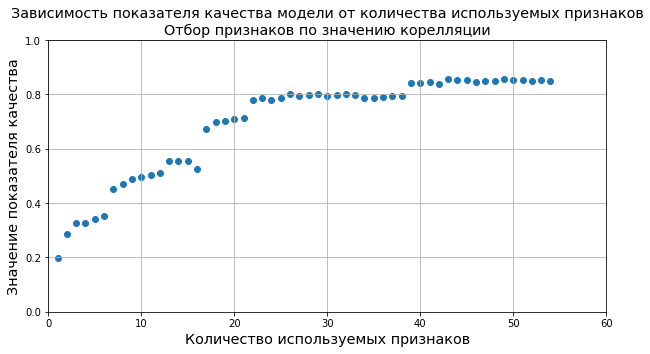

In [10]:
score_plot(result_corr, 'Отбор признаков по значению корелляции')
plt.show()

#### Выводы:
- отсортировали признаки по убыванию коэффициента корелляции с вектором целевых значений
- показатель качества модели относительно медленно возрастает с увеличением количества признаков, используемых для обучения модели
- с увеличением количества признаков показатель качества модели возрастает всё медленнее
- разрывы на графике можно объяснить тем, что коэффициент корелляции признаков не в полной мере отражает их вклад в повышение показателя качества модели

#### Отбор признаков на основе Information Value

In [11]:
# Рассчитаем оценку информативности признаков по методу mutual_info_classif
# Результат отсортируем в порядке убывания
info = pd.Series(mutual_info_classif(X_train, y_train), index = X.columns).sort_values(ascending = False)

In [12]:
result_info = score_calc(info.index)

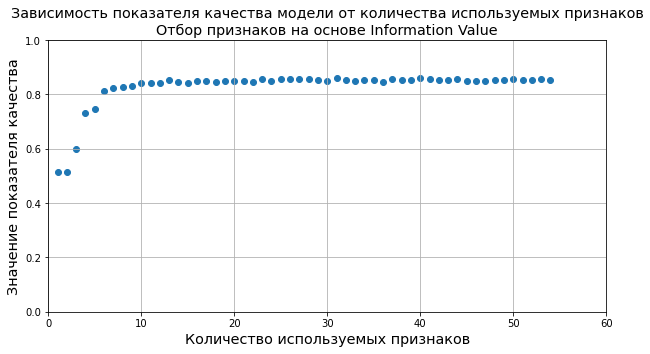

In [13]:
score_plot(result_info, 'Отбор признаков на основе Information Value')
plt.show()

#### Выводы:
- отсортировали признаки по убыванию оценки информативности
- показатель качества модели относительно быстро возрастает с увеличением количества признаков, используемых для обучения модели
- с увеличением количества признаков свыше определённого значения, показатель качества модели достигает насыщения и не изменяется

#### Отбор признаков на основе feature_impotance

In [14]:
# Обучим модель случайного леса и получим значимость признаков
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)
impot = pd.Series(model.feature_importances_, index = X.columns).sort_values(ascending = False)

In [15]:
result_impot = score_calc(impot.index)

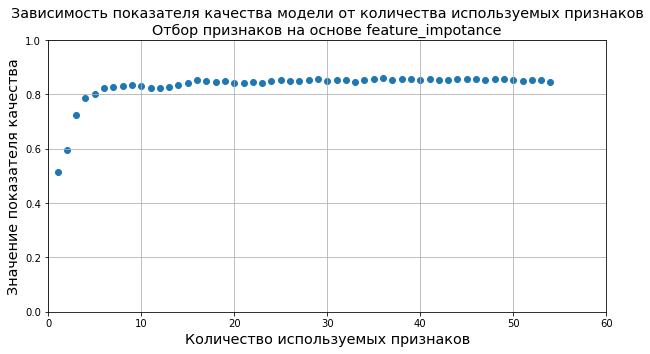

In [16]:
score_plot(result_impot, 'Отбор признаков на основе feature_impotance')
plt.show()

#### Выводы:
- отсортировали признаки по убыванию оценки важности признаков
- показатель качества модели относительно быстро возрастает с увеличением количества признаков, используемых для обучения модели
- с увеличением количества признаков свыше определённого значения, показатель качества модели достигает насыщения и не изменяется

#### Жадный отбор признаков

In [17]:
# Создадим два множества признаков: в одном все исходные признаки, во второе будем отбирать по жадному алгоритму
features_all = list(X.columns)
features_work = []
# Используем модель случайного леса
model = RandomForestClassifier(random_state = 42, n_jobs = -1)

In [18]:
result_selection = {}
# Выполняем перебор, пока во множестве исходных признаков не останется элементов
while len(features_all) != 0:
    # Словарь для временного хранения результатов
    scores = {}    
    # Перебираем признаки из множества исходных по одному
    for feature in features_all:
        # Обучаем модель
        model.fit(X_train[features_work + [feature]], y_train)
        # Оцениваем качество
        scores[feature] = model.score(X_test[features_work + [feature]], y_test)
    # Получаем название признака, с которым показатель качества модели макимальный
    feature_max = max(scores, key = scores.get)
    # Переносим найденный признак из исходного множества в рабочее
    features_all.remove(feature_max)
    features_work.append(feature_max)
    result_selection[len(features_work)] = max(scores.values())

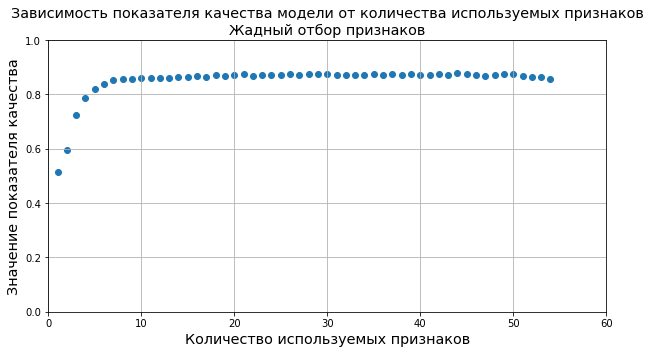

In [30]:
score_plot(result_selection, 'Жадный отбор признаков')
plt.show()

#### Жадное отбрасывание признаков

In [20]:
# Исходные признаки
features_all = list(X.columns)
# Отброшенные признаки
features_drop = []
# Используем модель случайного леса
model = RandomForestClassifier(random_state = 42, n_jobs = -1)

In [21]:
result_drop = {}
# Выполняем перебор, пока во множестве исходных признаков не останется элементов
while len(features_all) != 1:
    # Словарь для временного хранения результатов
    scores = {}    
    # Перебираем признаки из множества исходных по одному
    for feature in features_all:
        # Обучаем модель
        model.fit(X_train.drop(features_drop + [feature], axis = 1), y_train)
        # Оцениваем качество
        scores[feature] = model.score(X_test.drop(features_drop + [feature], axis = 1), y_test)
    # Получаем название признака, с которым показатель качества модели макимальный
    feature_max = max(scores, key = scores.get)
    # Переносим найденный признак из исходного множества в отброшенные
    features_all.remove(feature_max)
    features_drop.append(feature_max)
    result_drop[len(features_all)] = max(scores.values())

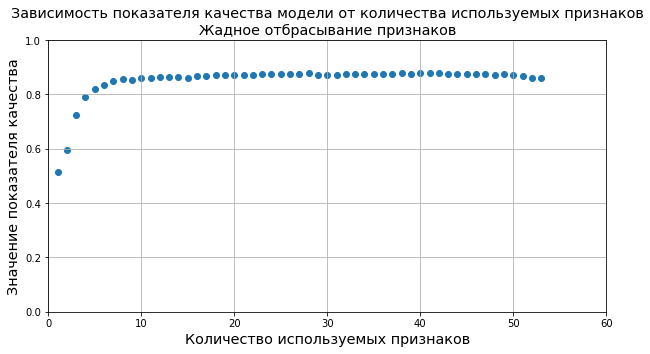

In [31]:
score_plot(result_drop, 'Жадное отбрасывание признаков')
plt.show()

#### Выводы:
- исследовали жадный отбор и жадное отбрасывание признаков
- показатель качества модели относительно быстро возрастает в обоих случаях, затем наблюдается насыщение
- графики для алгоритмов жадного отбора и жадного отбрасывания признаков практически совпадают

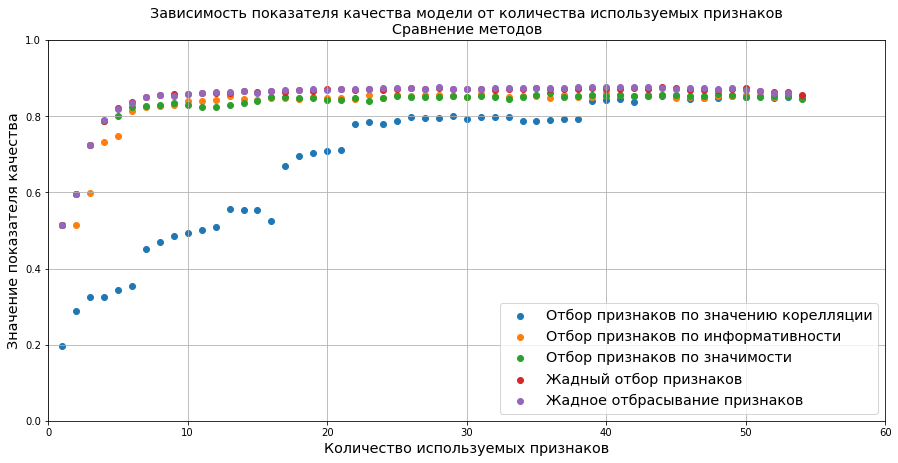

In [41]:
# Сравнение графиков
plt.figure(figsize = (15, 7))
plt.scatter(x = result_corr.keys(), y = result_corr.values(), label = 'Отбор признаков по значению корелляции')
plt.scatter(x = result_info.keys(), y = result_info.values(), label = 'Отбор признаков по информативности')
plt.scatter(x = result_impot.keys(), y = result_impot.values(), label = 'Отбор признаков по значимости')
plt.scatter(x = result_selection.keys(), y = result_selection.values(), label = 'Жадный отбор признаков')
plt.scatter(x = result_drop.keys(), y = result_drop.values(), label = 'Жадное отбрасывание признаков')
plt.xlim(0, 60)
plt.ylim(0, 1)
plt.grid()
plt.xlabel('Количество используемых признаков', fontsize = 'x-large')
plt.ylabel('Значение показателя качества', fontsize = 'x-large')
plt.title('Зависимость показателя качества модели от количества используемых признаков\nСравнение методов', fontsize = 'x-large')
plt.legend(fontsize = 'x-large')
plt.show()

#### Общие выводы:
- отбор признаков по значению корелляции показывает наихудшие показатели, качество модели растёт медленно
- отбор признаков по информативности или значимости обеспечивает относительно быстрый рост качества модели
- жадный отбор и жадное отбрасывание признаков показывает лучший результат, но требует больших вычислительных ресурсов
- среди рассмотренных методов оптимальнымим являеются методы отбора признаков по информативности или значимости с помощью модели случайного леса (с учётом скорости роста качества и невысоких требований к вычислительным ресурсам)